# Midterm Report - Project Notebook
## Galaxy Classification - Galaxy10 SDSS Dataset
### Authors: Daniel Blackston, Grayson Gill, Ethan Miller
#### Date: 04/04/2025
> Total Time to Run: ~10 min

### 1. Import Required Libraries

In [1]:
import os
import requests
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### 2. Read and Process Data

In [2]:
# set url and filename
url = "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5"
filename = "Galaxy10.h5"

# download dataset into file from url
if os.path.exists(filename):
    print(f"'{filename}' already exists in the current directory!")
else:
    response = requests.get(url, stream=True)
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=4096):
            if chunk:
                file.write(chunk)
    print(f"'{filename}' was successfully downloaded!")

# get the images and labels from the h5 file
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# flatten 4D array into 1D array for processing
n_samples, height, width, channels = images.shape
X = images.reshape(n_samples, height * width * channels)
y = labels

# normalize the image data
X = X.astype(np.float32) / 255.0

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

# fit the training and testing data with a scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

'Galaxy10.h5' already exists in the current directory!


### 3. Compare Performance of Three Models
## Model #1: One Vs Rest Classifier with Stochastic Gradient Descent

In [3]:
# apply PCA to reduce the number of features
pca = PCA(n_components=1000)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)

# train the model
model = OneVsRestClassifier(SGDClassifier(loss='log_loss', max_iter=5000, learning_rate='optimal'))
model.fit(pca_X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(loss='log_loss', max_iter=5000))

### Predict and Evaluate the Model

Classification Report for Stochastic Gradient Descent:

              precision    recall  f1-score   support

           0       0.23      0.48      0.31       346
           1       0.45      0.37      0.41       700
           2       0.43      0.39      0.41       629
           3       0.17      0.03      0.05        35
           4       0.59      0.48      0.53       153
           5       0.00      0.00      0.00         2
           6       0.64      0.39      0.48        59
           7       0.38      0.27      0.31       112
           8       0.17      0.05      0.08        91
           9       0.08      0.04      0.05        52

    accuracy                           0.37      2179
   macro avg       0.31      0.25      0.26      2179
weighted avg       0.40      0.37      0.37      2179



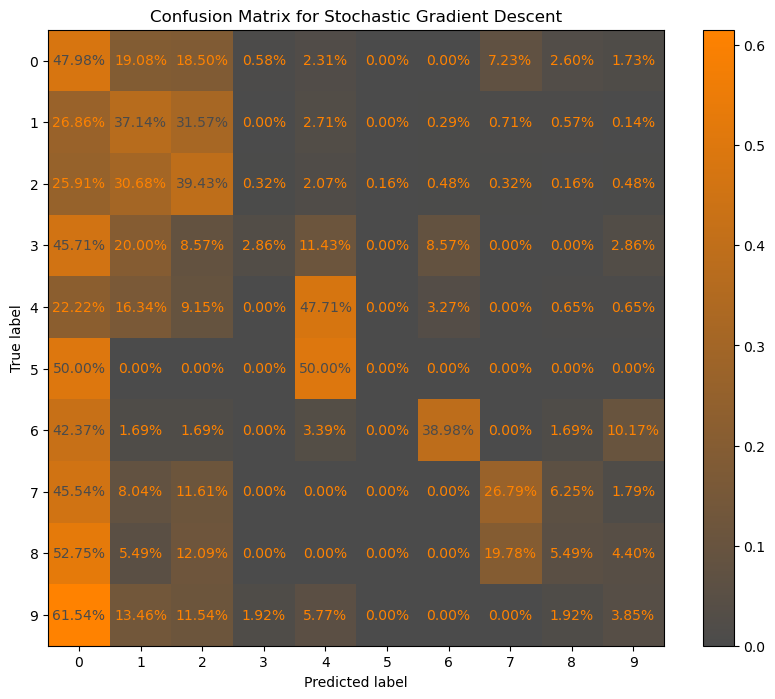

In [4]:
# make predictions
y_pred = model.predict(pca_X_test)

# show classification metrics
print("Classification Report for Stochastic Gradient Descent:\n")
print(classification_report(y_test, y_pred, zero_division=0.0))

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

# Display confusion matrix with color coding
custom_cmap = LinearSegmentedColormap.from_list('UT_colors', ['#4b4b4b', '#ff8200'])

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap=custom_cmap, ax=ax, values_format='.2%')

plt.title("Confusion Matrix for Stochastic Gradient Descent")
plt.show()


## Model #2: Random Forest Classifier

In [5]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

### Predict and Evaluate the Model

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.48      0.50      0.49       346
           1       0.77      0.97      0.86       700
           2       0.76      0.76      0.76       629
           3       0.67      0.06      0.11        35
           4       0.74      0.85      0.79       153
           5       0.00      0.00      0.00         2
           6       0.79      0.81      0.80        59
           7       0.48      0.30      0.37       112
           8       0.00      0.00      0.00        91
           9       0.50      0.02      0.04        52

    accuracy                           0.71      2179
   macro avg       0.52      0.43      0.42      2179
weighted avg       0.67      0.71      0.67      2179



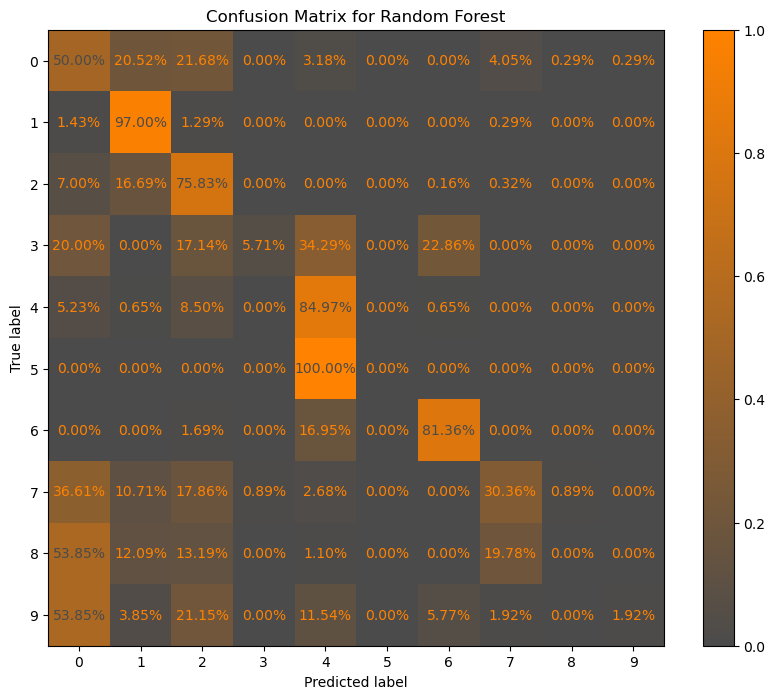

In [6]:
# make predictions
y_pred = model.predict(X_test)

# show classification metrics
print("Classification Report for Random Forest:\n")
print(classification_report(y_test, y_pred, zero_division=0.0))

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

# Display confusion matrix with color coding
custom_cmap = LinearSegmentedColormap.from_list('UT_colors', ['#4b4b4b', '#ff8200'])

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap=custom_cmap, ax=ax, values_format='.2%')

plt.title("Confusion Matrix for Random Forest")
plt.show()

### Plot Learning Curve

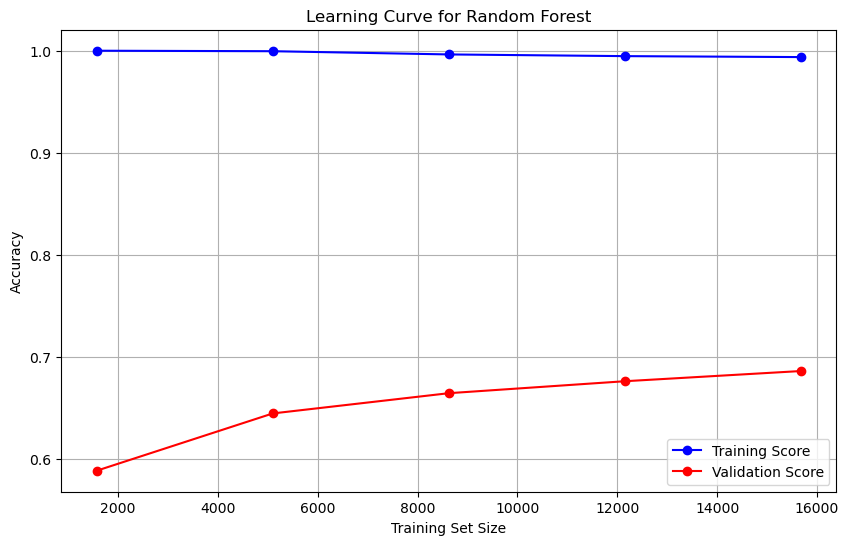

In [7]:
# get 10% to 100% of the training data
train_sizes = np.linspace(0.1, 1.0, 5)

# compute learning curve using 5 folds
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker="o")
plt.plot(train_sizes, test_mean, label="Validation Score", color="red", marker="o")

# Labels and legend
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.grid(True)
plt.show()

## Model #3: KNN Classifier

In [8]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

### Predict and Evaluate the Model

Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.36      0.33      0.35       346
           1       0.62      0.89      0.73       700
           2       0.66      0.62      0.64       629
           3       0.27      0.17      0.21        35
           4       0.75      0.67      0.71       153
           5       0.00      0.00      0.00         2
           6       0.78      0.54      0.64        59
           7       0.31      0.17      0.22       112
           8       0.25      0.02      0.04        91
           9       0.00      0.00      0.00        52

    accuracy                           0.59      2179
   macro avg       0.40      0.34      0.35      2179
weighted avg       0.55      0.59      0.56      2179



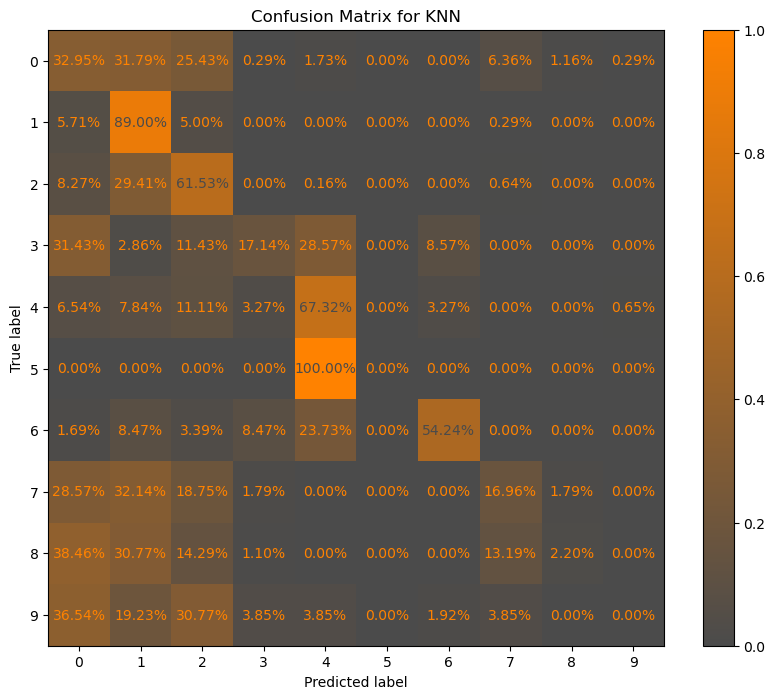

In [9]:
# make predictions
y_pred = model.predict(X_test)

# show classification metrics
print("Classification Report for KNN:\n")
print(classification_report(y_test, y_pred, zero_division=0.0))

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

# Display confusion matrix with color coding
custom_cmap = LinearSegmentedColormap.from_list('UT_colors', ['#4b4b4b', '#ff8200'])

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap=custom_cmap, ax=ax, values_format='.2%')

plt.title("Confusion Matrix for KNN")
plt.show()

### Plot Learning Curve

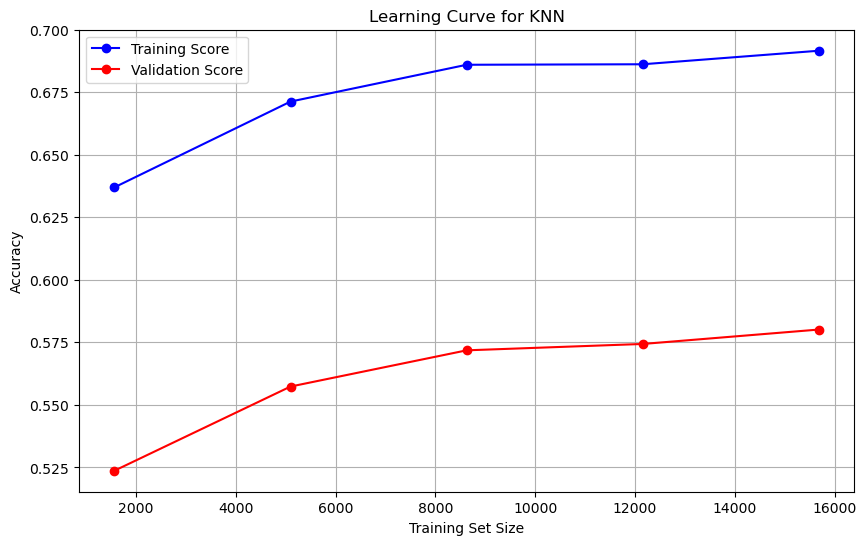

In [10]:
# get 10% to 100% of the training data
train_sizes = np.linspace(0.1, 1.0, 5)

# compute learning curve using 5 folds
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker="o")
plt.plot(train_sizes, test_mean, label="Validation Score", color="red", marker="o")

# Labels and legend
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for KNN")
plt.legend()
plt.grid(True)
plt.show()